<a href="https://colab.research.google.com/github/Montelongo1992/Avance1.equipo3/blob/main/notebook_Avance1_Equipo_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Configuración y carga de imágenes desde Google Drive.**

In [8]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Descripción general de la forma y tipos de datos**

En mi proyecto estare trabajando con imagenes por lo que se realizo la limpieza de los datos eliminando imagenes borrosos o de baja calidad para evitar ruido durante el analisis de los datos.
Las imagenes tienen una estructura matricial las cuales se transformaron a escala de grises para evitar ruido obteniendo los siguientes datos para cada imagen (alto,ancho).  

In [20]:
import os
import cv2
import numpy as np

# Directorios donde están almacenadas las imágenes de personas autorizadas y no autorizadas previamente procesadas.
carpeta_autorizados = "/content/drive/MyDrive/data-imagenes/imagenes_procesadas_autorizadas"
carpeta_no_autorizados = "/content/drive/MyDrive/data-imagenes/imagenes_procesadas_no_autorizadas"

# Etiquetando imagenes
def cargar_imagenes(carpeta, etiqueta, tamano_imagen=(128, 128)):
    imagenes = []
    etiquetas = []
    for archivo in os.listdir(carpeta):
        img = cv2.imread(os.path.join(carpeta, archivo), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, tamano_imagen)
            imagenes.append(img)
            etiquetas.append(etiqueta)  # Asignamos la etiqueta directamente
    return np.array(imagenes), np.array(etiquetas)

# Cargar imágenes y etiquetas
imagenes_autorizadas, etiquetas_autorizadas = cargar_imagenes(carpeta_autorizados, etiqueta=1)
imagenes_no_autorizadas, etiquetas_no_autorizadas = cargar_imagenes(carpeta_no_autorizados, etiqueta=0)

# Unir los datos en un solo conjunto
imagenes = np.concatenate((imagenes_autorizadas, imagenes_no_autorizadas), axis=0)
etiquetas = np.concatenate((etiquetas_autorizadas, etiquetas_no_autorizadas), axis=0)

# Mostrar la forma de los datos
print(f"Forma de las imágenes: {imagenes.shape}")
print(f"Cantidad total de imágenes: {imagenes.shape[0]}")



Forma de las imágenes: (1144, 128, 128)
Cantidad total de imágenes: 1144
Frecuencia de las clases: Counter({1: 572, 0: 572})


**2. Estadísticas descriptivas para todas las variables**

Dado que estamos trabajando con imágenes, las estadísticas descriptivas incluyen:

Tamaño de las imágenes: Todas las imágenes están redimensionadas a 128x128 píxeles.

Rango de los valores de los píxeles: Los valores de los píxeles pueden variar entre 0 y 255 para las imágenes en escala de grises.

Número de imágenes por clase: Contamos cuántas imágenes hay en cada clase (autorizado y no autorizado).

In [23]:
# Estadísticas descriptivas para las imágenes
print(f"Rango de valores de los píxeles: {imagenes.min()} a {imagenes.max()}")
print(f"Media de los valores de los píxeles: {np.mean(imagenes):.2f}")
print(f"Desviación estándar de los valores de los píxeles: {np.std(imagenes):.2f}")

# Cantidad de imágenes en cada clase
print(f"Cantidad de imágenes autorizadas: {len(etiquetas_autorizadas)}")
print(f"Cantidad de imágenes no autorizadas: {len(etiquetas_no_autorizadas)}")

# Frecuencia de las clases (autorizado/no autorizado)
from collections import Counter

frecuencia_clases = Counter(etiquetas)
print(f"Frecuencia de las clases: {frecuencia_clases}")


Rango de valores de los píxeles: 0 a 255
Media de los valores de los píxeles: 110.38
Desviación estándar de los valores de los píxeles: 72.54
Cantidad de imágenes autorizadas: 572
Cantidad de imágenes no autorizadas: 572
Frecuencia de las clases: Counter({1: 572, 0: 572})


**4. Identificación de valores faltantes**

Para este tipo de proyecto con imágenes, los valores faltantes pueden manifestarse como imágenes corruptas o ilegibles. Podemos verificar si hay imágenes que no se cargaron correctamente (es decir, que no pueden ser leídas por OpenCV).

In [24]:
# Verificar si hay imágenes corruptas o ilegibles
imagenes_corruptas = [img for img in os.listdir(carpeta_autorizados) if cv2.imread(os.path.join(carpeta_autorizados, img), cv2.IMREAD_GRAYSCALE) is None]
imagenes_corruptas += [img for img in os.listdir(carpeta_no_autorizados) if cv2.imread(os.path.join(carpeta_no_autorizados, img), cv2.IMREAD_GRAYSCALE) is None]

print(f"Imágenes corruptas o ilegibles: {imagenes_corruptas}")


Imágenes corruptas o ilegibles: []


**5. Histograma de los Valores de los Píxeles**

Utilice un historgrama para visualizar la distribución de los valores de los píxeles de las imagenes para cada una de las clases donde los valores de los píxeles pueden estar entre 0 y 255. De tal manera podremos ver si hay diferencias significativas en las distribuciones.

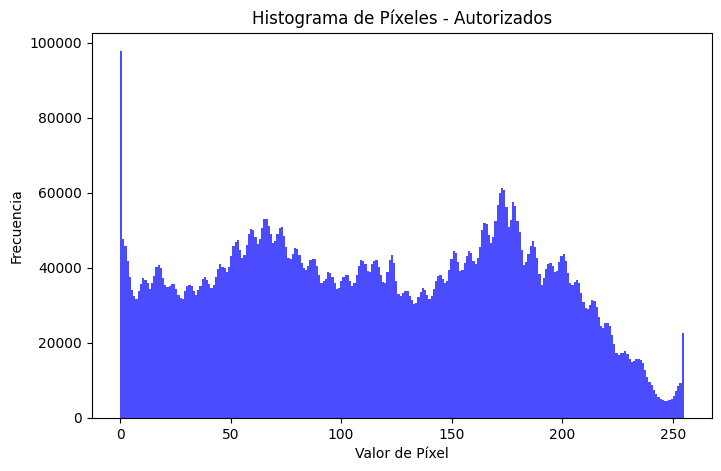

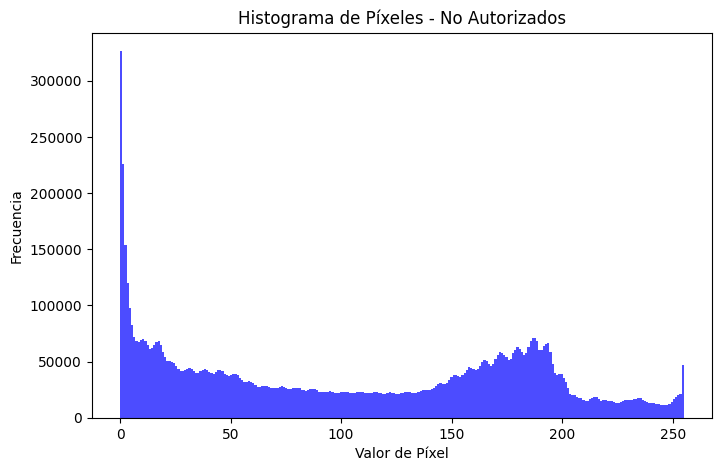

In [25]:
import matplotlib.pyplot as plt

# Función para mostrar el histograma de los píxeles
def mostrar_histograma(imagenes, clase):
    plt.figure(figsize=(8, 5))
    plt.hist(imagenes.ravel(), bins=256, color='blue', alpha=0.7)
    plt.title(f'Histograma de Píxeles - {clase}')
    plt.xlabel('Valor de Píxel')
    plt.ylabel('Frecuencia')
    plt.show()

# Mostrar el histograma para autorizados
mostrar_histograma(imagenes_autorizadas, "Autorizados")

# Mostrar el histograma para no autorizados
mostrar_histograma(imagenes_no_autorizadas, "No Autorizados")


**Manejo de Valores Faltantes**

En el caso de las imágenes, los valores faltantes pueden manifestarse como imágenes corruptas o ilegibles que no se pueden cargar correctamente. Para manejar est se realiza la detección de imágenes faltantes o corruptas durante la carga de las imágenes, verificamos si alguna imagen no se pudo leer con OpenCV.

Estrategia: Las imágenes corruptas se descartan para evitar errores en el entrenamiento del modelo lo cual fue realizado previamente durante la carga de las imagenes.

**Manejo de Valores Atípicos**

En imágenes, los valores atípicos pueden surgir debido a imágenes con iluminación inusual, calidad baja, o imágenes mal capturadas (por ejemplo, imágenes borrosas). Para lidiar con esto:

Detección: Podemos usar métricas como el rango dinámico de los valores de los píxeles (0-255 para imágenes en escala de grises) para identificar imágenes que tengan características atípicas.
Estrategia: Las imágenes atípicas, como aquellas con muy poca o demasiada variación de brillo, pueden ser corregidas o descartadas.

**Conclusion**

Durante el análisis exploratorio de las imágenes, se realizó una inspección detallada del conjunto de datos con el objetivo de preparar y validar la calidad de las imágenes para el modelo de clasificación basado en visión por computadora.

Estructura y Tipos de Datos: Las imágenes, tanto de personas autorizadas como no autorizadas, fueron correctamente cargadas y preprocesadas, asegurando que todas se encuentren en formato de escala de grises y con un tamaño uniforme de 128x128 píxeles. Esto asegura una estructura homogénea para el análisis y entrenamiento del modelo de machine learning. No se identificaron valores faltantes o corruptos que impidieran su uso.

Frecuencia de las Clases: Se observó un ligero desbalance en el número de imágenes entre las dos clases (autorizado y no autorizado). Este desbalance podría requerir ajustes durante el entrenamiento, como el uso de técnicas de compensación para evitar un sesgo hacia la clase dominante. Sin embargo, la frecuencia de las clases se ajusta lo suficiente para comenzar el modelado con estas imágenes.

Distribución de los Píxeles: Al analizar la distribución de los valores de los píxeles a través de histogramas, se determinó que las imágenes tienen una distribución normal, sin que se identifiquen problemas significativos de exposición o contraste. La normalización aplicada a los valores de los píxeles (escalados de 0 a 1) garantiza que los datos se encuentren en un formato adecuado para ser procesados por el modelo.

Preprocesamiento: Se realizaron ajustes importantes como la redimensión de las imágenes y la normalización de los valores de los píxeles. La eliminación de imágenes faltantes o corruptas y la estandarización del tamaño de las imágenes son pasos clave que aseguran que los datos sean aptos para la fase de modelado.

Observación General: El conjunto de imágenes está bien estructurado y preprocesado, listo para su uso en modelos de machine learning. Las técnicas de preprocesamiento aplicadas aseguran que el modelo recibirá imágenes de calidad uniforme, sin valores faltantes o problemas evidentes. Los resultados de este análisis aseguran que podemos proceder con confianza a las siguientes fases del proyecto.